## Preparation

Welcome to the Vectice tutorial notebook!


Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice Python library:
- Dataset versions
- Model versions
- Runs and lineage

For more information on the tutorial, please refer to the "Vectice Tutorial Page" inside the app.



## Setup

Install Vectice

In [ ]:
#Install Vectice Python library 
# In this tutorial we will do code versioning using github, we also support gitlab
# and bitbucket: !pip install -q "vectice[github, gitlab, bitbucket]"
!pip install --q vectice[github]

In [1]:
#Verify if Vectice python library was installed
!pip3 show vectice

Name: vectice
Version: 0.21.0
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: python-dotenv, requests
Required-by: 


Here, the our data is stored in GCS. We should install the following GCS packages in order to be able to get it.

In [6]:
## GCS packages
!pip3 install --q fsspec
!pip3 install --q gcsfs


In [7]:
## Import the required packages for data preparation and model training
import string
from math import sqrt
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


### Connect and authenticate to Vectice API

In [25]:
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType
from vectice.entity.model import ModelType
import logging
logging.basicConfig(level=logging.INFO)

# Specify the API endpoint for Vectice.
os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"

# To use the Vectice Python library, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "API Tokens" tab in your workspace
# Copy and paste your API key here
os.environ['VECTICE_API_TOKEN'] = "QkZWM9EJD.0XeWYNgrVy7K69jq5azA4QkZWM9EJDpBPOLMm1xbl2w8vGR03d"

# Next, you need to specify the tutorial project where you will run this notebook using a 
# "Project Token". You can find the "Project Token" under the "Settings" tab of your project.

# Copy and paste your Project Token here
# autocode = True enables you to track your git changes for your code automatically everytime you execute a run (see below).
vectice = Vectice(project_token="BpR8Go6eh84vybzZaLWj", autocode= True)


INFO:vectice.auth:Vectice: Refreshing token... 
INFO:vectice.auth:Success!
INFO:vectice.auth:Vectice: Validating project token... 
INFO:vectice.auth:The entered token is OK, and allows you to work on the '[Completed Tutorial] Predicting house prices in King County' Project, part of the 'Sample - Everyone' Workspace


## Create a run

 A run is an execution of a job. You can think of a job like a grouping of runs.

When creating a run we need to specify:

 1) a job name (mandatory): Job names are unique for each project
 
 2) a job type (optional)
 
 3) a run name (optional): The run names are unique for each job

Job names, job types and run names are useful to group and search runs in the Vectice UI.
You can also specify inputs when you start your run and outputs when you end it. The inputs can be code, dataset and model versions and the outputs can be dataset and model versions.


In [ ]:
vectice.create_run("job_name", JobType.PREPARATION, "Run Name").with_properties([("run key", "run prop")])
vectice.start_run()
vectice.end_run()

You can also use the Python context manager (with) to manage runs. This helps to end the run and it also marks its status as failed in the Vectice UI in case we have an error in the run.

In [ ]:
vectice.create_run("job_name", JobType.PREPARATION, "Run name").with_properties([("run key", "run prop")])
with vectice.start_run() as run:
    #Add your code here
    run.add_outputs()

## Create a dataset and a dataset version

There are three ways to create a dataset in Vectice:

1- Creating a dataset without a connection

In [11]:
### Creating a dataset without a connection
vectice.create_dataset(dataset_name="dataset name",data_properties=[("key", "prop"), ("key2", "prop2")])

INFO:Vectice:Dataset: dataset name has been successfully created.


728

2- Creating a dataset with a connection

Getting the list of connections in the Workspace:

In [ ]:
vectice.list_connections()

If you have a connection, you can use the following method to create a dataset and declare your files:
 
 vectice.create_dataset_with_connection_name(connection_name="connection name",
                                             dataset_name="dataset name",
                                             files=["The path to your file"],
                                             data_properties=[("key", "prop"), ("key2", "prop2")])

We can also use vectice.create_dataset_with_connection_id()

3- Create a dataset and a dataset version at the same time

When creating a new dataset version, if the parent dataset doesn't exist in the project, a new dataset is created automatically and it will contain the first version we created.

In [ ]:
dataset_version = vectice.create_dataset_version().with_parent_name("new dataset").with_properties([("key", "prop")])

The Vectice library automatically detects if there have been changes to the dataset you are using. If it detects changes, it will generate a new version of your dataset automatically. Else, it's going to use the latest version of your dataset.

We can get the list of the datasets we have in the project by calling **vectice.list_datasets()**

In [ ]:
vectice.list_datasets().list

We can also get the list of dataset versions by calling **vectice.list_dataset_versions(dataset_id)**

### Attach a dataset version as input or output to a run

In [ ]:
vectice.create_run("job_name", JobType.PREPARATION).with_properties([("run key", "run prop")])
vectice.start_run(inputs=[dataset_version])
vectice.end_run

You can also use another existing dataset version by using the existing version name, number or id (if you use the id, you don't need to specify the parent dataset name or id).

In [ ]:
dataset_version = vectice.create_dataset_version().with_parent_name("dataset").with_existing_version_number(1)
vectice.create_run("job_name", JobType.PREPARATION).with_properties([("run key", "run prop")])
vectice.start_run(inputs=[dataset_version])
vectice.end_run

## Create a code version

Vectice enables you to track your source code by creating code versions. This can be done automatically and manually.

### Creating a code version automatically

If you are using your local environment with GIT installed or JupyterLab etc... the code tracking can be automated by setting  autocode=True when creating the Vectice instance.

### Creating a code version manually

You can create a code version manually by using:

1- **vectice.create_code_version_with_github_uri()** for GitHub

2- **vectice.create_code_version_with_gitlab_uri()** for GitLab

3- **vectice.create_code_version_with_bitbucket_uri()** for Bitbucket

In [ ]:
## Example for code versioning with GitHub
code_version = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples",
        "Notebooks/Tutorial/Jupyter_notebooks/GCS_data/Tutorial_notebook_GCS_data.ipynb")

vectice.create_run("Job name", JobType.PREPARATION).with_properties([("run key", "run prop")])
vectice.start_run(inputs=[code_version])
vectice.end_run()

## Creating models and model versions

Vectice enables you to create your models and model versions and log the metrics, hyperparameters and model properties

When creating a model version, if there is a model with the same name as the given model name in your project, a new model version is added to the given model. Else, a new model is created automatically.

In [ ]:
Vectice.create_model_version().with_parent_name('Regressor')

You can declare your model metrics by using .with_metrics(metrics), hyperparameters and properties by using .with_properties(properties), type by usnig .with_type(), the used algorithme by using .with_algorithm(Algorithme name) and model attachments, by using .with_attachments(Attachments), when creating a model version.

We also use with_user_version() for model versioning. You can provide a version name for your model version. An error will be thrown if the given user version already exists and if you don't provide a version name, the version name will be generated automatically.


### Attach a model version as input or output of a run

In [ ]:
vectice.create_run("job_name", JobType.PREPARATION).with_properties([("run key", "run prop")])
vectice.start_run(inputs=[dataset_version])
metrics = [('metric', value), ('metric 2', value)]
properties = [('property', value), ('property 2', value)]
model_version = vectice.create_model_version().with_user_version().with_parent_name("Regressor").with_algorithm("Decision Tree").with_type(ModelType.REGRESSION).with_properties(properties).with_metrics(metrics).with_attachments(["DecisionTree_6.png"])

vectice.end_run(outputs=[model_version])

# Exercice

### Getting the data from GCS

We are going to load data stored in Google Cloud Storage, that is provided by Vectice for this tutorial.


You need a service account key to be able to get the data from your buckets on GCS. You can find more information about how to generate a key to access your data on GCS [here](https://doc.vectice.com/connections/google.html#google-cloud-storage).

In [ ]:
## Provide the path to the service account JSON key file 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'readerKey.json'

# Once your file is loaded you can view your dataset in a Pandas dataframe.
df = pd.read_csv('gs://vectice_tutorial/kc_house_data_cleaned.csv')

# Run head to make sure the data was loaded properly
df.head()


### Data preparation

Let's split the dataset into train and test sets and save them in GCS. The GCS code has been commented out as the data has already been generated.

In [18]:
# The Vectice library automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. Else, it's going
# to use the latest version of your dataset.
# You can also use another dataset version by calling .with_existing_version_name('version name')

input_ds_version = vectice.create_dataset_version().with_parent_name("cleaned_kc_house_data")

# For this run, we will use the job name "80/20 Split" and the job type "PREPARATION"
# You can have multiple runs with the same job name
# We can use the Python context manager (with) to end the run and make its status as failed
## in the Vectice UI in case we have an error
vectice.create_run("80/20 Split", JobType.PREPARATION, "Data preparation")
with vectice.start_run(inputs=[input_ds_version]) as run:

# We will use an 80/20 split to prepare the data
    test_size = 0.2

# We will set the random seed so we always generate the same split.
    random_state = 42

    train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
    X = df.drop("price", axis=1).values
    y = df["price"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create new versions of the training and testing dataset if the data has changed.
# We will use the existing dataset created by Albert, so that we can append new 
# dataset versions to it.
    train_ds_version = vectice.create_dataset_version().with_parent_name("train_cleaned_kc_house_data")
    test_ds_version = vectice.create_dataset_version().with_parent_name("test_cleaned_kc_house_data")

# Attach the output datasets to the run.
    run.add_outputs(outputs=[train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train


array([[ 4.00000e+00,  3.00000e+00,  3.61000e+03, ..., -1.22342e+02,
         3.56800e+03,  1.89480e+04],
       [ 3.00000e+00,  2.00000e+00,  2.08000e+03, ..., -1.22285e+02,
         1.92000e+03,  7.00000e+03],
       [ 4.00000e+00,  2.50000e+00,  2.09000e+03, ..., -1.22221e+02,
         1.51000e+03,  7.40200e+03],
       ...,
       [ 3.00000e+00,  1.00000e+00,  1.46000e+03, ..., -1.22191e+02,
         1.15000e+03,  5.92600e+03],
       [ 3.00000e+00,  2.25000e+00,  1.62000e+03, ..., -1.22137e+02,
         1.60000e+03,  7.91000e+03],
       [ 4.00000e+00,  3.50000e+00,  3.38000e+03, ..., -1.22379e+02,
         2.22000e+03,  8.33000e+03]])

## Modeling

We can get the list of the models existing in the project by calling **vectice.list_models()**

In [ ]:
vectice.list_models().list

### Decision tree model

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 144649.5566489278
Mean Absolute Error: 95872.63972094451


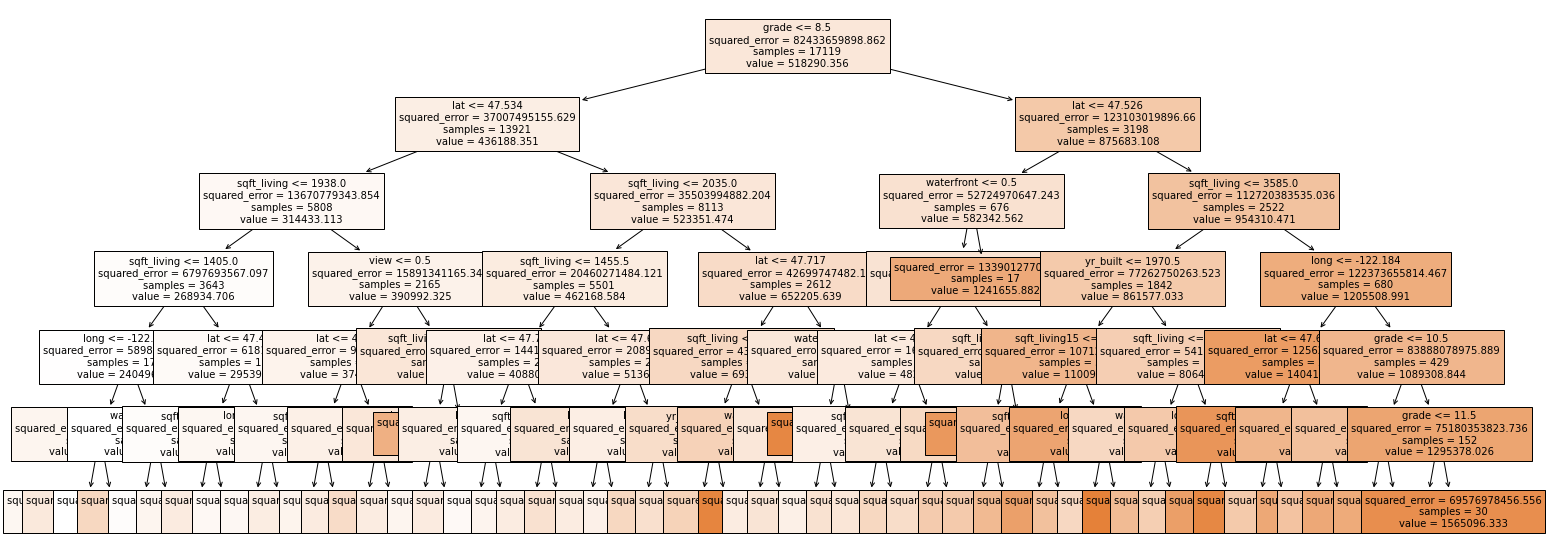

In [21]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 6

vectice.create_run("DT-Model", JobType.TRAINING)

# We can use the Python context manager (with) to end the run and make its status as failed
## in the Vectice UI in case we have an error
with vectice.start_run(inputs=[train_ds_version,test_ds_version]) as run:

    dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
    dtr.fit(X_train,y_train)
    dtr_pred = dtr.predict(X_test) 

    data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
    plt.figure(figsize=(25, 10))
    plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)
    plt.savefig("DecisionTree_6.png")
# We save the plot in order to be able to attach to the model version.
## We can attach the decision tree plot to the model version by using .with_attachments([Attachments])
    
    MAE = mean_absolute_error(dtr_pred, y_test)
    RMSE = sqrt(mean_squared_error(dtr_pred, y_test))

    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)
    
# Here we use with_user_version() to create a new model version. You can provide a version name 
## for your model version. An error will be thrown if the given user version already exists and
### if you don't provide a version name, the version name will be generated automatically.

    properties = [("Tree Depth",str(tree_depth))]
    metrics = [("RMSE", RMSE), ("MAE", MAE)]
    model_version = vectice.create_model_version().with_user_version().with_parent_name("Regressor").with_algorithm("Decision Tree").with_type(ModelType.REGRESSION).with_properties(properties).with_metrics(metrics).with_attachments(["DecisionTree_6.png"])

## We add the created model version as output of the run
    run.add_outputs(outputs=[model_version])

### Model versions table 

You can also get all the model versions you created in previous runs, for offline analysis and understanding in more details what's driving the models performance.

In [31]:
vectice.list_model_versions_dataframe(1859)

,createdDate,name,versionNumber,status,algorithmName,isStarred,MAE,RMSE,min_samples,nb_trees,Tree Depth
1,2021-10-26T10:12:04.673Z,Version 7,7,EXPERIMENTATION,Random Forest,False,78768.05865246612,124175.30672204353,60,60,NaN
0,2021-10-26T10:11:56.574Z,Version 6,6,STAGING,Random Forest,False,73234.96135977643,115802.72669445473,30,60,NaN
2,2021-10-26T10:11:39.228Z,Version 5,5,EXPERIMENTATION,Random Forest,False,73478.21057536665,116025.56105472318,30,30,NaN
3,2021-10-26T10:07:21.877Z,Version 4,4,PRODUCTION,Decision Tree,True,95872.63972094451,144649.5566489278,NaN,NaN,6
4,2021-10-26T10:07:13.569Z,Version 3,3,EXPERIMENTATION,Decision Tree,False,112088.19615621041,165154.56185163363,NaN,NaN,4
5,2021-10-26T10:07:08.448Z,Version 2,2,EXPERIMENTATION,Decision Tree,False,141604.0933708193,203604.21325245287,NaN,NaN,2
6,2021-10-26T10:06:53.736Z,Version 1,1,EXPERIMENTATION,Linear Regression,False,109761.9792426024,156149.06199382708,NaN,NaN,NaN


###  Update your model

Vectice enables you to update your model by using **vectice.update_model()**

In [24]:
vectice.update_model(parent_name="Regressor", model_type=ModelType.REGRESSION, description="Model description")

INFO:Vectice:Model: 'Regressor' has been updated


Thank you and congratulations! You have succesfully completed this tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice Python library. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice Python library and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
